In [6]:
import os

from tqdm import tqdm
from conf_ensemble_dataset_in_memory import ConfEnsembleDataset
from torch_geometric.data import Batch, DataLoader
from torch.utils.data import ConcatDataset
from litschnet import LitSchNet

In [2]:
data_dir = 'data/'

In [3]:
# run once to preprocess datasets and generate chunks
# dataset = ConfEnsembleDataset()
# dataset = ConfEnsembleDataset(dataset='platinum') # 16G

In [7]:
pdbbind_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('pdbbind')]
pdbbind_n_chunks = len(pdbbind_chunks)

In [8]:
%%time
iteration = 0
with open(os.path.join(data_dir, 'scaffold_splits', f'train_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]

with open(os.path.join(data_dir, 'scaffold_splits', f'val_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    val_smiles = f.readlines()
    val_smiles = [smiles.strip() for smiles in val_smiles]

with open(os.path.join(data_dir, 'scaffold_splits', f'test_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]

train_datasets = []
val_datasets = []
test_datasets = []

for chunk_number in tqdm(range(pdbbind_n_chunks)) :

    dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                  smiles_list=train_smiles)
    train_datasets.append(dataset)

    dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                  smiles_list=val_smiles)
    val_datasets.append(dataset)

    dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                  smiles_list=test_smiles)
    test_datasets.append(dataset)

100%|█████████████████████████████████████████████| 3/3 [03:15<00:00, 65.04s/it]

CPU times: user 3min 12s, sys: 2.65 s, total: 3min 15s
Wall time: 3min 15s


In [9]:
train_dataset = ConcatDataset(train_datasets)
val_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

In [10]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
for batch in test_loader :
    break

In [13]:
import pytorch_lightning as pl
from torch_geometric.nn.models import SchNet

from typing import Optional

import os
import warnings
import os.path as osp
from math import pi as PI

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Sequential, Linear, ModuleList
import numpy as np

from torch_scatter import scatter
from torch_geometric.data.makedirs import makedirs
from torch_geometric.data import download_url, extract_zip, Dataset
from torch_geometric.nn import radius_graph, MessagePassing

class AtomicSchNet(SchNet) :
    def forward(self, z, pos, batch=None):
        assert z.dim() == 1 and z.dtype == torch.long
        batch = torch.zeros_like(z) if batch is None else batch

        h = self.embedding(z)

        edge_index = radius_graph(pos, r=self.cutoff, batch=batch,
                                  max_num_neighbors=self.max_num_neighbors)
        row, col = edge_index
        edge_weight = (pos[row] - pos[col]).norm(dim=-1)
        edge_attr = self.distance_expansion(edge_weight)

        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_weight, edge_attr)

        h = self.lin1(h)
        h = self.act(h)
        h = self.lin2(h)

        if self.dipole:
            # Get center of mass.
            mass = self.atomic_mass[z].view(-1, 1)
            c = scatter(mass * pos, batch, dim=0) / scatter(mass, batch, dim=0)
            h = h * (pos - c.index_select(0, batch))

        if not self.dipole and self.mean is not None and self.std is not None:
            h = h * self.std + self.mean

        if not self.dipole and self.atomref is not None:
            h = h + self.atomref(z)

        return h

class LitSchNet(pl.LightningModule):
    def __init__(self, task='rmsd'):
        super().__init__()
        self.schnet = AtomicSchNet()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
        assert task in ['rmsd', 'tfd']
        self.task = task
        
        #self.automatic_optimization=False

    def forward(self, batch):
        pred = self.schnet(batch.z.long(), batch.pos, batch.batch)
        if self.task == 'rmsd' :
            pred = self.leaky_relu(pred)
        elif self.task == 'tfd' :
            pred = self.sigmoid(pred)
        return pred

    def training_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
                # If "monitor" references validation metrics, then "frequency" should be set to a
                # multiple of "trainer.check_val_every_n_epoch".
            },
        }
    
    def _get_target(self, batch) :
        if self.task == 'rmsd' :
            return batch.rmsd
        elif self.task == 'tfd' :
            return batch.tfd

In [14]:
experiment_name = f'scaffold_split_{iteration}_new'
if experiment_name in os.listdir('lightning_logs') :
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)

In [35]:
with torch.no_grad() :
    preds = litschnet(batch)

In [16]:
batch.data_id[0]

'O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1'

In [17]:
import pickle
with open('data/raw/ccdc_generated_conf_ensemble_library.p', 'rb') as f :
    cel = pickle.load(f)

In [124]:
from mol_viewer import MolViewer
from rdkit.Chem.Draw import rdMolDraw2D
import copy
from rdkit import Chem

In [161]:
import matplotlib as mpl
import matplotlib.cm as cm
def score_to_rgba_color(score, vmin=0, vmax=1) :
    cmap = cm.YlOrRd
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    normalized_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgba = normalized_map.to_rgba(score)
    return rgba
    #return mpl.colors.to_hex(rgba).replace('#', '0x')

In [172]:
import pandas as pd
df = pd.DataFrame(columns=['smiles', 'conf_i', 'atom_i', 'contribution'])
for batch_i in batch.batch.unique() :
    pred_is = preds[batch.batch == batch_i]
    pred_is = pred_is.numpy()
    smiles = batch.data_id[batch_i]
    ce = cel.get_conf_ensemble(smiles)
    for atom_i, pred in enumerate(pred_is) :
        new_row = pd.Series({'smiles' : smiles,
                             'conf_i' : batch_i.item(),
                             'atom_i' : atom_i,
                             'contribution' : pred[0]})
        df = df.append(new_row, ignore_index=True)

In [173]:
smiles = 'O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1'
df_smiles = df[df['smiles'] == smiles]
df_smiles

,smiles,conf_i,atom_i,contribution
0,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,0,0,0.039185
1,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,0,1,0.039186
2,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,0,2,0.053623
3,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,0,3,-0.000911
4,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,0,4,0.034488
...,...,...,...,...
1002,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,52,14,0.078919
1003,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,52,15,0.072495
1004,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,52,16,0.061468
1005,O=C1[C@@H](O)c2ccccc2N1CCc1ccccc1,52,17,0.044202


In [236]:
cross_tab_prop = pd.crosstab(index=df_smiles['conf_i'],
                             columns=df_smiles['atom_i'],
                             values=df_smiles['contribution'],
                             aggfunc='sum',
                             normalize="index")
cross_tab_prop.head()

atom_i,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
conf_i,,,,,,,,,,,,,,,,,,,
0,0.041959,0.041960,0.057420,-0.000975,0.036930,0.063625,0.064998,0.099284,0.031140,0.064492,-0.001505,0.079739,0.069702,0.056239,0.029659,0.061420,0.122117,0.059767,0.022030
1,-0.000174,0.056781,0.056576,0.032307,0.028635,0.062074,0.100879,0.108855,0.033358,0.056813,-0.000485,0.095278,0.061722,0.050295,0.029455,0.060400,0.094738,0.053952,0.018540
2,-0.000242,0.055613,0.050809,0.065830,0.025153,0.055320,0.094934,0.129800,0.027117,0.051833,-0.000218,0.084533,0.063772,0.053492,0.010836,0.050586,0.097606,0.051494,0.031732
3,-0.000045,0.062766,0.060011,0.036220,0.021070,0.066000,0.067379,0.083571,0.008397,0.060691,-0.001648,0.079029,0.067829,0.054210,0.023666,0.062522,0.135690,0.076586,0.036055
4,0.002867,0.058285,0.046837,0.066710,0.021112,0.058197,0.086325,0.100252,0.023949,0.054385,-0.000929,0.066442,0.071505,0.052743,0.019329,0.052562,0.114963,0.064566,0.039901


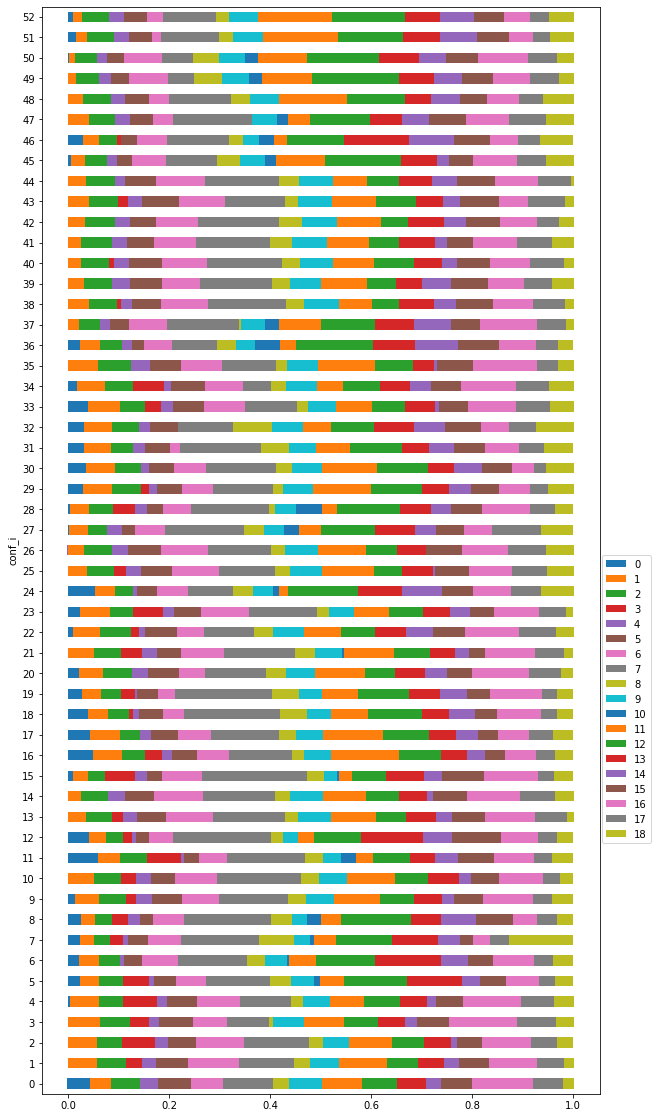

In [238]:
cross_tab_prop.plot(kind='barh', 
                    stacked=True, 
                    figsize=(10, 20))
plt.legend(loc='best', bbox_to_anchor=(0.60, 0., 0.5, 0.5))

In [240]:
cross_tab_prop = pd.crosstab(index=df_smiles['conf_i'],
                             columns=df_smiles['atom_i'],
                             values=df_smiles['contribution'],
                             aggfunc='sum')
cross_tab_prop.head()

atom_i,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
conf_i,,,,,,,,,,,,,,,,,,,
0,0.039185,0.039186,0.053623,-0.000911,0.034488,0.059417,0.060700,0.092718,0.029081,0.060227,-0.001405,0.074466,0.065093,0.052520,0.027697,0.057358,0.114041,0.055815,0.020573
1,-0.000179,0.058402,0.058192,0.033230,0.029453,0.063847,0.103760,0.111963,0.034311,0.058436,-0.000499,0.097999,0.063484,0.051731,0.030296,0.062125,0.097443,0.055493,0.019070
2,-0.000266,0.061147,0.055865,0.072380,0.027656,0.060824,0.104380,0.142716,0.029816,0.056991,-0.000240,0.092945,0.070117,0.058815,0.011914,0.055619,0.107319,0.056618,0.034889
3,-0.000042,0.058186,0.055632,0.033577,0.019532,0.061184,0.062462,0.077472,0.007784,0.056262,-0.001527,0.073261,0.062879,0.050253,0.021938,0.057959,0.125787,0.070997,0.033424
4,0.002951,0.059995,0.048211,0.068667,0.021731,0.059904,0.088858,0.103192,0.024652,0.055980,-0.000957,0.068391,0.073603,0.054290,0.019896,0.054104,0.118336,0.066460,0.041072


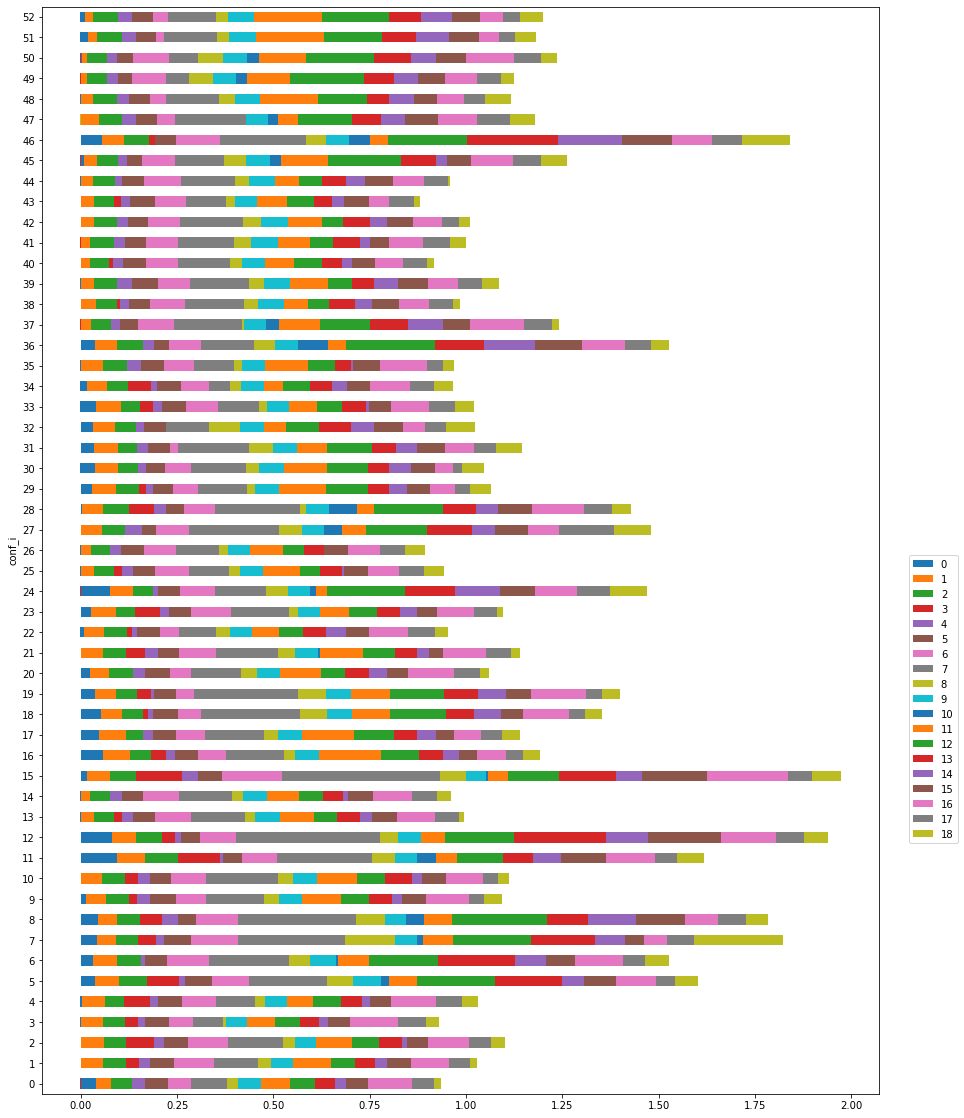

In [242]:
cross_tab_prop.plot(kind='barh', 
                    stacked=True, 
                    figsize=(15, 20))
plt.legend(loc='best', bbox_to_anchor=(0.60, 0., 0.5, 0.5))

In [185]:
import matplotlib.pyplot as plt

In [208]:
conf_is = range(53)
atom_is = range(19)
atom_contributions = []
for atom_i in atom_is :
    df_atom = df_smiles[df_smiles['atom_i'] == atom_i]
    atom_contributions.append(df_atom['contribution'].values.tolist())

In [209]:
len(atom_contributions[0])

53

ValueError: operands could not be broadcast together with shapes (0,) (53,) 

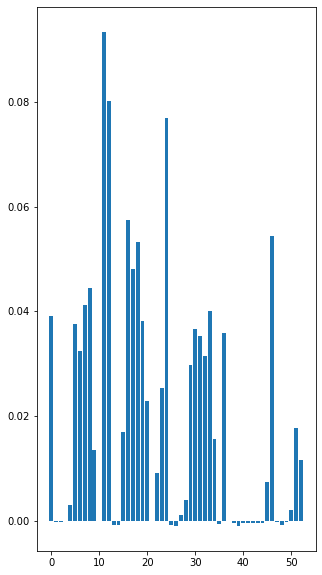

In [210]:
plt.figure(figsize=(5,10))
plt.bar(conf_is, atom_contributions[0])
for atom_i, contributions in enumerate(atom_contributions) :
    previous_contributions = np.array([atom_contributions[:atom_i]])
    current_values = previous_contributions.sum(0) + np.array(contributions)
    plt.bar(conf_is, current_values)
plt.show()

In [ ]:
x = ['A', 'B', 'C', 'D']
y1 = np.array([10, 20, 10, 30])
y2 = np.array([20, 25, 15, 25])
y3 = np.array([12, 15, 19, 6])
y4 = np.array([10, 29, 13, 19])
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.xlabel("Teams")
plt.ylabel("Score")
plt.legend(["Round 1", "Round 2", "Round 3", "Round 4"])
plt.title("Scores by Teams in 4 Rounds")
plt.show()

<AxesSubplot:xlabel='conf_i', ylabel='contribution'>

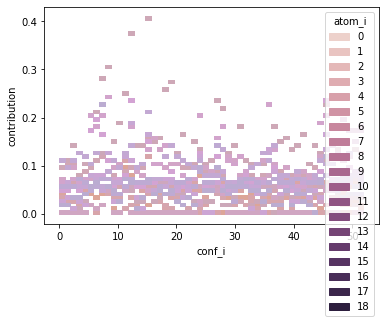

In [178]:
import seaborn as sns
sns.histplot(data=df_smiles, x='conf_i', y='contribution', hue='atom_i', multiple='stack', bins=53)

In [163]:
for batch_i in batch.batch.unique() :
    pred_is = preds[batch.batch == batch_i]
    pred_is = pred_is.numpy()
    smiles = batch.data_id[batch_i]
    ce = cel.get_conf_ensemble(smiles)
    #assert np.array_equal(ce.get_conf_positions(conf_id=0).astype(np.float32), batch.pos[batch.batch == 0].numpy())
    
    copy_mol = copy.deepcopy(ce.mol)
    Chem.rdDepictor.Compute2DCoords(copy_mol)
    
    d = rdMolDraw2D.MolDraw2DCairo(500, 500)
    d.drawOptions().addAtomIndices=True
    atoms = range(copy_mol.GetNumAtoms())
    colors = {i : score_to_rgba_color(pred_is[i][0], pred_is.min(), pred_is.max()) for i in atoms}
    rdMolDraw2D.PrepareAndDrawMolecule(d, 
                                       copy_mol, 
                                       highlightAtoms=atoms, 
                                       highlightAtomColors=colors)
    d.FinishDrawing()
    d.WriteDrawingText(f'atomic_contributions/mol{batch_i}_relative.png')

In [157]:
for batch_i in batch.batch.unique() :
    pred_is = preds[batch.batch == batch_i]
    smiles = batch.data_id[batch_i]
    ce = cel.get_conf_ensemble(smiles)
    #assert np.array_equal(ce.get_conf_positions(conf_id=0).astype(np.float32), batch.pos[batch.batch == 0].numpy())
    pred_is = pred_is.numpy()
    
    copy_mol = copy.deepcopy(ce.mol)
    Chem.rdDepictor.Compute2DCoords(copy_mol)
    
    d = rdMolDraw2D.MolDraw2DCairo(500, 500)
    d.drawOptions().addAtomIndices=True
    atoms = range(copy_mol.GetNumAtoms())
    colors = {i : score_to_rgba_color(pred_is[i][0], 0, 1) for i in atoms}
    rdMolDraw2D.PrepareAndDrawMolecule(d, 
                                       copy_mol, 
                                       highlightAtoms=atoms, 
                                       highlightAtomColors=colors)
    d.FinishDrawing()
    d.WriteDrawingText(f'atomic_contributions/mol{batch_i}_absolute.png')

In [98]:
from rdkit.Chem.Draw import MolToImage
MolToImage(mol=ce.mol, size=(300, 300), highlightAtoms=[0, 1], highlightColor=((0,0,0), (1,0,0)))

TypeError: No registered converter was able to produce a C++ rvalue of type float from this Python object of type tuple

In [80]:
mol_viewer = MolViewer()
mol_viewer.view(mol=ce.mol)

interactive(children=(IntSlider(value=0, description='conf_id', max=52), Output()), _dom_classes=('widget-inte…

In [70]:
for atom in ce.mol.GetAtoms() :
    print(atom.GetAtomicNum())

8
6
6
8
6
6
6
6
6
6
7
6
6
6
6
6
6
6
6
